### ISI和cv计算并行版

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
# 自定义函数
from import_fun import HH_model, Iz_model, FHN_model, Euler, RK4, spikes_eval
from import_fun import record_spike_times, calculate_isi, calculate_cv

In [123]:
@njit
def ISI_CV_fhn(N, method, dt, A):
    t = 0

    # nodes = HH_model
    # nodes = Iz_model

    # 创建节点
    nodes = FHN_model
    # 模型参数
    params_nodes = {
        "a": 0.1,
        "b": 0.8,
        "c": 0.7,
        "Iex": 0.,
    }
    th_up = 1    # 放电阈上值
    th_down = 1  # 放电阈下值
    
    v0 = np.random.rand(N)
    w0 = np.random.rand(N)
    vars_nodes = np.vstack((v0, w0))

    N_vars = 2  # 变量的数量

    # 模型放电变量
    flag = np.zeros(N, dtype=np.int32)           # 模型放电标志(>0, 放电)
    flaglaunch = np.zeros(N, dtype=np.int32)     # 模型开始放电标志(==1, 放电刚刚开始)
    firingTime = np.zeros(N)                     # 记录放电时间(上次放电)
    # 初始化峰值时间记录相关变量
    max_spikes = 1000                                 # 假设每个神经元最多记录 1000 次放电
    spike_times = np.full((N, max_spikes), np.nan)
    spike_counts = np.zeros(N, dtype=np.int32)   # 放电次数计数

    # 正弦函数参数
    w = 1.    # 频率

    for _ in range(500_00):
        I = np.zeros((N_vars, N))
        I[0, :] += A * np.cos(w* t)
        params_list = list(params_nodes.values())
        method(nodes, vars_nodes, t, dt, I, params_list)  #

        spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)

        t += dt  # 时间前进

    mem = []
    time = []
    # 计算ISI和CV
    for _ in range(1000_00):
        I = np.zeros((N_vars, N))
        I[0, :] += A * np.cos(w* t)
        params_list = list(params_nodes.values())
        method(nodes, vars_nodes, t, dt, I, params_list)  #

        spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)
        # 记录峰值时间
        record_spike_times(flaglaunch, t, spike_times, spike_counts, max_spikes)

        t += dt  # 时间前进
        mem.append(vars_nodes[0].copy())
        time.append(t)

    # isi_array = calculate_isi(spike_times, spike_counts, N)[0]

    # cv_array = calculate_cv(spike_times, spike_counts, N)[0]

    # return isi_array, cv_array
    return mem, time

In [124]:
dt = 0.01
method = Euler   # （Euler, RK4）
N = 1
# Iex = 0
Iex_list1 = np.linspace(0, 100, 1000)

In [125]:
# isi_array, cv_array = ISI_CV(N, method, dt, Iex)

In [126]:
# @njit(parallel=True)
# def parallel_isi_cv(Iex_list, N, method, dt):
#     n = len(Iex_list)
#     N = 100
#     isi_list = np.full((n, N), np.nan)
#     cv_list = np.full(n, np.nan)
    
#     for i in prange(n):
#         Iex = Iex_list[i]
#         isi_array, cv_array = ISI_CV(N, method, dt, Iex)
#         len_isi = len(isi_array)
#         if len_isi > N: N = 100
#         isi_list[i, :len_isi] = isi_array[:N]
#         cv_list[i] = cv_array
        
#     return isi_list, cv_list

In [127]:
# isi_list, cv_list = parallel_isi_cv(Iex_list1, N, method, dt)

In [128]:
# plt.plot(Iex_list1, isi_list, 'o',  markersize=2, color="k")
# plt.xlabel("Iex")
# plt.ylabel("ISI")
# plt.show()

In [129]:
# plt.plot(Iex_list1, cv_list, 'o',  markersize=2, color="k")
# plt.xlabel("Iex")
# plt.ylabel("cv")
# plt.show()

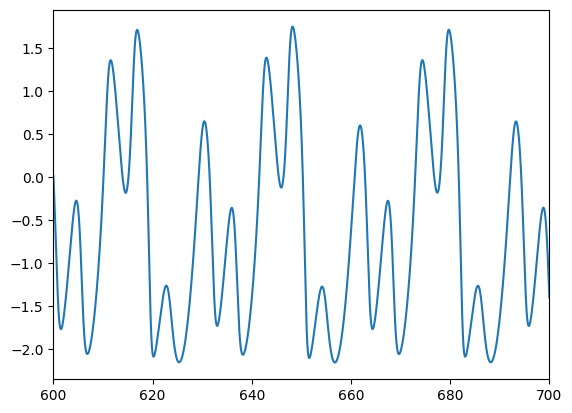

In [130]:
mem, time = ISI_CV_fhn(N, method, dt, 1.2)
plt.plot(time, mem)
plt.xlim(600, 700)
plt.show()